In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.chdir(".")
from parc.data.data import EnergeticMatDataPipeLine as EmData
from parc import misc, metrics, visualization
from parc.model import model


2024-01-18 11:39:29.415874: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data pipeline

In [ ]:
# Get data and normalization
state_seq_whole, vel_seq_whole = EmData.clip_raw_data(idx_range = (0,150))
state_seq_norm = EmData.data_normalization(state_seq_whole,3)
vel_seq_norm = EmData.data_normalization(vel_seq_whole,2)

# Training


### Stage 1: Differentiator training

In [3]:
# Create tf.dataset
dataset_input = tf.data.Dataset.from_tensor_slices((state_seq_norm[0][:,:,:,:3],vel_seq_norm[0][:,:,:,:2]))
dataset_label = tf.data.Dataset.from_tensor_slices((state_seq_norm[0][:,:,:,-3:],vel_seq_norm[0][:,:,:,-2:]))
dataset = tf.data.Dataset.zip((dataset_input, dataset_label))
dataset = dataset.shuffle(buffer_size = 2192) 
dataset = dataset.batch(8)

2024-01-08 10:20:02.287387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78651 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0


In [ ]:
tf.keras.backend.clear_session()
parc = model.PARCv2(n_state_var = 3, n_time_step = 1, step_size= 1/15, solver = "rk", mode = "differentiator_training")
parc.differentiator.load_weights('parc2_diff_rk4.h5')
parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999))
parc.fit(dataset, epochs = 50, shuffle = True)

In [ ]:
parc.differentiator.save_weights('parc2_diff_rk4_256.h5')

### Stage 2: Data-driven integration training

In [ ]:
# Pretrain integrator
tf.keras.backend.clear_session()
parc = model.PARCv2(n_state_var = 3, n_time_step = 1, step_size= 1/15, solver = "euler", mode = "integrator_training")
parc.differentiator.load_weights('./parc2_diff_euler.h5')
parc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001, beta_1 = 0.9, beta_2 = 0.999))
parc.fit(dataset, epochs = 50, shuffle = True)

In [ ]:
parc.integrator.save_weights('parc2_int_euler.h5')

In [4]:
import time
import os
import numpy as np
import skimage
from skimage.measure import block_reduce


def clip_raw_data(idx_range, sequence_length=2, n_state_var=3, purpose = "diff_training"):
    state_seq_whole = []
    vel_seq_whole = []

    for i in range(idx_range[0],idx_range[1]):
        file_path = os.path.join(os.sep,'project','SDS','research', 'Nguyen_storage', 'data', 'single_void_data', f'void_{i}.npy')
        if os.path.exists(file_path):
            raw_data = np.float32(np.load(file_path))
            data_shape = raw_data.shape
            if data_shape[2] > sequence_length:
                print(i)
                npad = ((0, abs(data_shape[0] - 512)), (0, abs(data_shape[1] - 1024)), (0, 0))
                raw_data = np.pad(raw_data, pad_width=npad, mode='edge')
                raw_data = np.expand_dims(raw_data, axis=0)
                raw_data = skimage.measure.block_reduce(raw_data[:,:,:,:], (1,4,4,1),np.max)

                data_shape = raw_data.shape
                num_time_steps = data_shape[-1] // (n_state_var + 2)
                if purpose == "diff_training":
                    j_range = num_time_steps - sequence_length
                else:
                    j_range = 1
                state_seq_case = [np.concatenate([raw_data[:, :, :192, (j + k) * (n_state_var + 2):\
                                                        (j + k) * (n_state_var + 2) + n_state_var] \
                                                        for k in range(sequence_length)], axis=-1) \
                                                        for j in range  (j_range)] 

                vel_seq_case = [np.concatenate([raw_data[:, :, :192, (j + k) * (n_state_var + 2) +  n_state_var :\
                                                        (j + k) * (n_state_var + 2) + n_state_var + 2] \
                                                        for k in range(sequence_length)], axis=-1) \
                                                        for j in range (j_range)] 


                state_seq_whole.extend(state_seq_case)
                vel_seq_whole.extend(vel_seq_case)

    state_seq_whole = np.concatenate(state_seq_whole, axis=0)
    vel_seq_whole = np.concatenate(vel_seq_whole, axis=0)

    return state_seq_whole, vel_seq_whole

# Normalization
def data_normalization(input_data,no_of_channel):
    norm_data = np.zeros(input_data.shape)
    min_val = []
    max_val = []
    for i in range(no_of_channel):
        norm_data[:,:,:,i::no_of_channel] = ((input_data[:,:,:,i::no_of_channel] - np.amin(input_data[:,:,:,i::no_of_channel])) / (np.amax(input_data[:,:,:,i::no_of_channel]) - np.amin(input_data[:,:,:,i::no_of_channel])) + 1E-9)
        min_val.append(np.amin(input_data[:,:,:,i::no_of_channel]))
        max_val.append(np.amax(input_data[:,:,:,i::no_of_channel]))
    return norm_data, min_val, max_val

def data_normalization_test(input_data, min_val, max_val, no_of_channel):
    norm_data = np.zeros(input_data.shape)
    for i in range(no_of_channel):
        norm_data[:,:,:,i::no_of_channel] = ((input_data[:,:,:,i::no_of_channel] - min_val[i]) / (max_val[i] - min_val[i] + 1E-9))
    return norm_data

# Validation

In [ ]:
state_seq_whole, vel_seq_whole = clip_raw_data(idx_range = (150,200), sequence_length = 15, n_state_var = 3, purpose = "test")
state_seq_norm_test = data_normalization_test(state_seq_whole, state_seq_norm[1], state_seq_norm[2],3)
vel_seq_norm_test = data_normalization_test(vel_seq_whole, vel_seq_norm[1], vel_seq_norm[2],2)

## Load model

In [ ]:
tf.keras.backend.clear_session()
parc_rk = model.PARCv2(n_state_var = 3, n_time_step = 14, step_size= 1/15, solver = "rk4", mode= "integrator_training")
parc_rk.compile()
parc_rk.differentiator.load_weights('parc2_diff_rk4.h5')
parc_rk.integrator.load_weights('parc2_int_rk4.h5')

In [3]:
parc_rk.save('parcv2_em.keras')

## Field evolution plot

In [21]:
def data_denormalization(input_data, min_val, max_val, no_of_channel):
    norm_data = np.zeros(input_data.shape)
    for i in range(no_of_channel):
        norm_data[:,:,:,i::no_of_channel] = (input_data[:,:,:,i::no_of_channel] * (max_val[i] - min_val[i] + 1E-9)) + min_val[i]
    return norm_data


In [25]:
pred_out = data_denormalization(pred,min_val_state,max_val_state, no_of_channel = 5)

In [35]:
np.save('./plotting/em/parcv2_em.npy',pred_out)

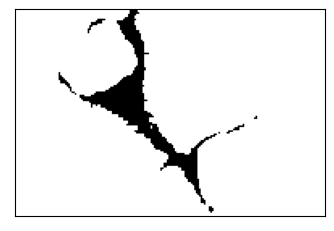

In [25]:
fig = plt.figure(figsize=(4, 6))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(np.squeeze(state_seq_norm_test[case_idx, :, :, 2]), cmap="gray", vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
for i in range(15):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(np.squeeze(Temp_gt[21,:,:,i]))
    ax[1].imshow(np.squeeze(Temp_pred_parc_rk[21,:,:,i]))
    plt.show()

### Quantitative analysis

In [ ]:
state_rk = []
outlier = [0, 3, 30, 31, 32, 33, 18, 19, 11]
# outlier = []
for idx in range(34):
    if idx not in outlier:
        print(idx)
        state_var_current = state_seq_norm_test[idx:idx+1,:,:,0:3]
        velocity_current = vel_seq_norm_test[idx:idx+1,:,:,0:2]
        pred_state = parc_rk.predict([state_var_current,velocity_current])
        pred_state_case = np.concatenate(pred_state, axis = -1)
        print(pred_state_case.shape)
        state_rk.append(pred_state_case)
state_rk = np.concatenate(state_rk, axis = 0)
print(state_rk.shape)       

In [196]:
def plot_sensitivity(y_true, y_pred_euler, y_pred_rk, metric, ts):
    """sensitivity plot comparing true and prediction
    :param y_true:  (tuple)
    :param y_pred:  (tuple)
    :param metric:  (str)   metric for plotting. {hs_temp, hs_area, rate_hs_temp, rate_hs_area}
    """

    if metric == "hs_temp" or metric == "hs_area":
        ts = np.linspace(3.16, 15.01, ts)
    elif metric == "rate_hs_temp" or metric == "rate_hs_area":
        ts = np.linspace(3.16, 14.22, ts - 1)
    else:
        print(
            "Wrong metric selection. Possible metrics are: 'hs_temp', 'hs_area', 'rate_hs_temp', 'rate_hs_area"
        )

    col_true, col_pred, col_yel = "#277DA1", "#F94144", "#F9C74F"
    plt.figure(figsize=(13, 10))

    # mean values
    plt.plot(ts, y_true[0], color=col_true, lw=2.5, label="Ground truth")
    plt.plot(ts, y_pred_rk[0], color=col_pred, lw=2.5, label="PARC-RK4")
#     plt.plot(ts, y_pred_euler[0], color=col_yel, lw=2.5, label="PARC-Euler")

    # plot intervals
    plt.fill_between(ts, y_true[1], y_true[2], color=col_true, alpha=0.2)
    plt.fill_between(ts, y_pred_rk[1], y_pred_rk[2], color=col_pred, alpha=0.2)
#     plt.fill_between(ts, y_pred_euler[1], y_pred_euler[2], color=col_yel, alpha=0.2)

    # corresponding titles and wordings based on the metric
    if metric == "hs_temp":
        plt.title(r"Ave. Hotspot Temperature ($T_{hs}$)", fontsize=32, pad=15)
        plt.xlabel(r"t ($ns$)", fontsize=28)
        plt.ylabel(r" $T_{hs}$ ($K$)", fontsize=28)
        plt.axis([3.16, 15.01, 0, 5000])
    elif metric == "hs_area":
        plt.title(r"Hotspot Area ($A_{hs}$)", fontsize=32, pad=15)
        plt.xlabel(r"t ($ns$)", fontsize=28)
        plt.ylabel(r"$A_{hs}$ ", fontsize=28)
        plt.axis([3.16, 15.01, 0, 25])
    elif metric == "rate_hs_temp":
        plt.title(
            r"Ave. Hotspot Temperature Rate of Change ($\dot{T_{hs}}$)",
            fontsize=32,
            pad=15,
        )
        plt.xlabel(r"t ($ns$)", fontsize=28)
        plt.ylabel(r"$\dot{T_{hs}}$ ($K$/$ns$)", fontsize=28)
        plt.axis([3.16, 15.01, -30, 1200])
    else:
        plt.title(r"Hotspot Area Rate of Change ($\dot{A_{hs}}$)", fontsize=32, pad=15)
        plt.xlabel(r"t ($ns$)", fontsize=28)
        plt.ylabel(r"$\dot{A_{hs}}$", fontsize=28)
        plt.axis([3.16, 15.01, 0, 10])

    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.legend(loc=2, fontsize=28)
    plt.show()


In [114]:
## Preprocess temperature data
# Get temperature field evolution
# Temp_gt = np.delete(state_seq_norm_test, outlier, 0)
# Temp_gt = Temp_gt[:,:,:,3::3]    # Ground truth temperature field evolution
Temp_gt = state_seq_norm_test[:,:,:,3::3]    # Ground truth temperature field evolution
# Temp_gt = np.clip(Temp_gt,0,1)
Temp_pred_parc_rk = state_rk[:,:,:,0::5]   # PARC prediction temperature field evolution
Temp_pred_parc_euler = state_euler[:,:,:,0::5]   # PARC prediction temperature field evolution

# # Denormalize temperature field evolution
Temp_gt = misc.scale_temperature(temperatures = Temp_gt, start_ts = 0, max_temp = 5000, min_temp = 300)
Temp_pred_parc_rk = misc.scale_temperature(temperatures = Temp_pred_parc_rk, start_ts = 0, max_temp = 5000, min_temp = 300)
Temp_pred_parc_euler = misc.scale_temperature(temperatures = Temp_pred_parc_euler, start_ts = 0, max_temp = 5000, min_temp = 300)

# Compute sensitivity of ground truth data
gt_hs_temp, gt_hs_area = metrics.calculate_hotspot_metric(Temp_gt[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)
gt_rate_hs_temp,gt_rate_hs_area = metrics.calculate_hotspot_metric_rate_of_change(Temp_gt[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)

# Compute sensitivity of PARC prediction
parc_hs_temp_rk, parc_hs_area_rk = metrics.calculate_hotspot_metric(Temp_pred_parc_rk[:,:,:,0:], cases_range = (0,25), n_timesteps =15)
parc_rate_hs_temp_rk, parc_rate_hs_area_rk = metrics.calculate_hotspot_metric_rate_of_change(Temp_pred_parc_rk[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)

# Compute sensitivity of PARC prediction
parc_hs_temp_euler, parc_hs_area_euler = metrics.calculate_hotspot_metric(Temp_pred_parc_euler[:,:,:,0:], cases_range = (0,25), n_timesteps =15)
parc_rate_hs_temp_euler, parc_rate_hs_area_euler = metrics.calculate_hotspot_metric_rate_of_change(Temp_pred_parc_euler[:,:,:,0:], cases_range = (0,25), n_timesteps = 15)

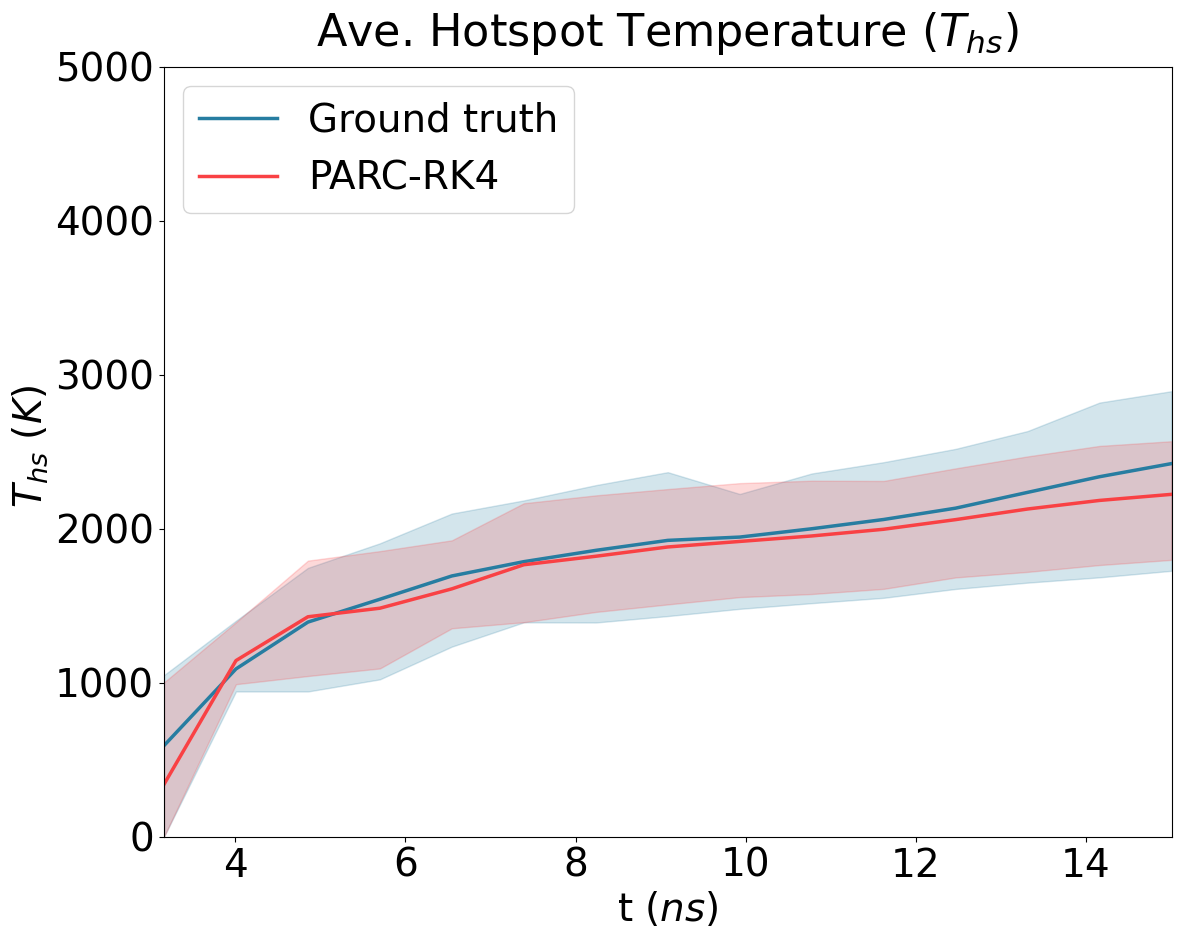

In [197]:
plot_sensitivity(y_true=gt_hs_temp, y_pred_rk=parc_hs_temp_rk, y_pred_euler = parc_hs_temp_euler,  metric='hs_temp',ts=15)

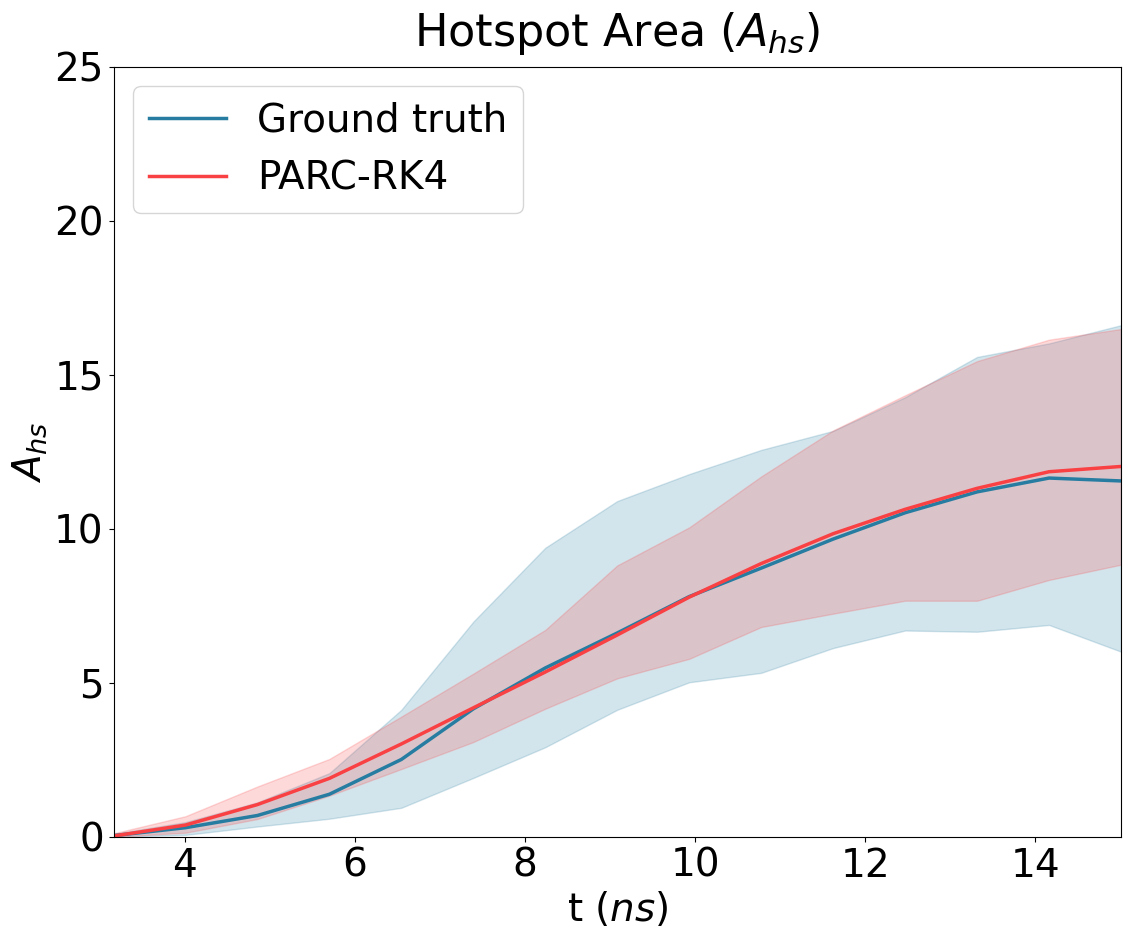

In [198]:
plot_sensitivity(y_true=gt_hs_area, y_pred_rk=parc_hs_area_rk, y_pred_euler = parc_hs_area_euler, metric='hs_area',ts=15)

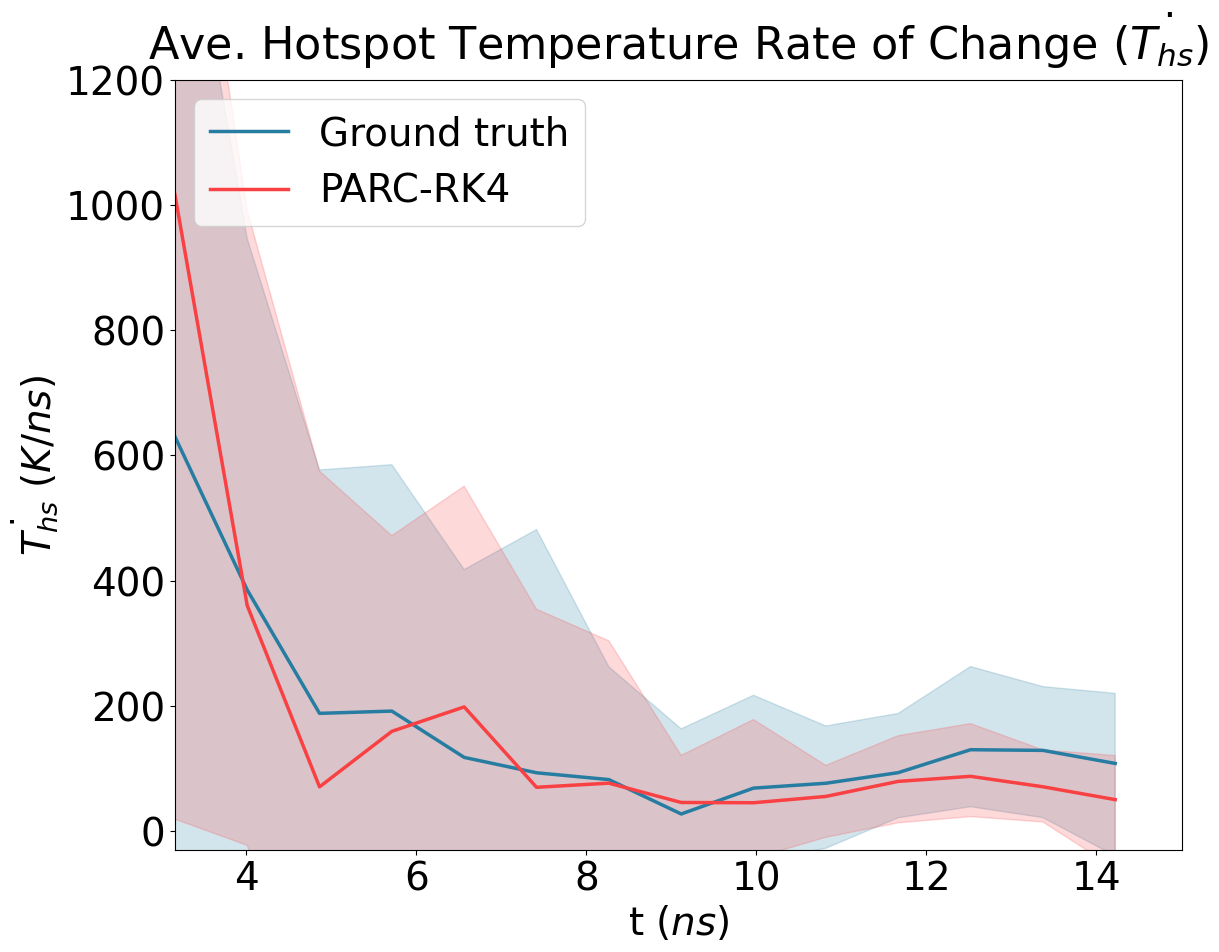

In [199]:
plot_sensitivity(y_true=gt_rate_hs_temp, y_pred_rk=parc_rate_hs_temp_rk, y_pred_euler = parc_rate_hs_temp_euler, metric='rate_hs_temp',ts=15)

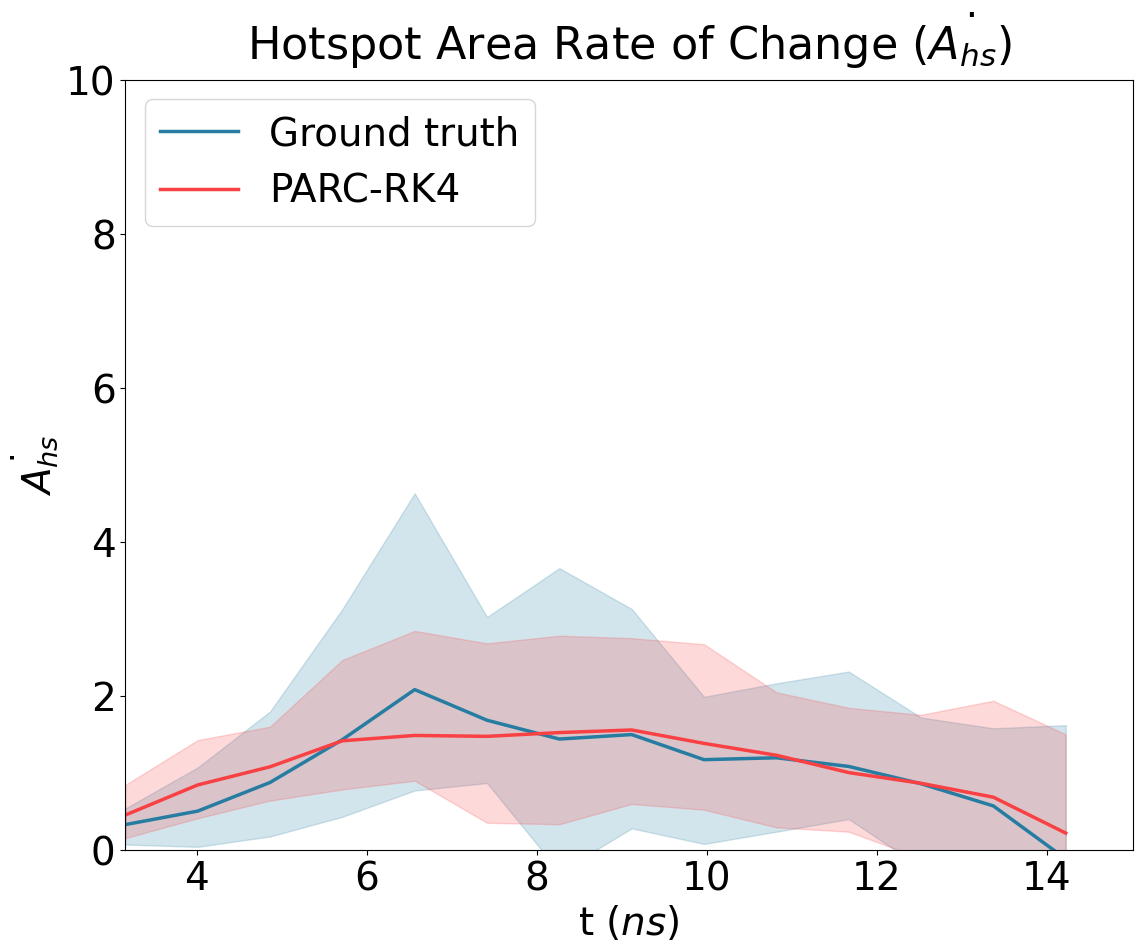

In [200]:
plot_sensitivity(y_true=gt_rate_hs_area, y_pred_rk=parc_rate_hs_area_rk, y_pred_euler = parc_rate_hs_area_euler, metric='rate_hs_area',ts=15)

In [202]:
## Preprocess temperature data
# Get temperature field evolution
# Temp_gt = np.delete(state_seq_norm_test, outlier, 0)
# Temp_gt = Temp_gt[:,:,:,3::3]    # Ground truth temperature field evolution
P_gt = vel_seq_norm_test[:,:,:,4::3]    # Ground truth temperature field evolution
# Temp_gt = np.clip(Temp_gt,0,1)
P_pred_parc_rk = state_rk[:,:,:,1::5]   # PARC prediction temperature field evolution
Temp_pred_parc_euler = state_euler[:,:,:,0::5]   # PARC prediction temperature field evolution

# # Denormalize temperature field evolution
Temp_gt = misc.scale_temperature(temperatures = Temp_gt, start_ts = 0, max_temp = 50e9, min_temp = -2e9)
Temp_pred_parc_rk = misc.scale_temperature(temperatures = Temp_pred_parc_rk, start_ts = 0, max_temp = 50e9, min_temp = -2e9)
Temp_pred_parc_euler = misc.scale_temperature(temperatures = Temp_pred_parc_euler, start_ts = 0, max_temp = 5000, min_temp = 300)

In [ ]:
plot_sensitivity(y_true=gt_rate_hs_area, y_pred_rk=parc_rate_hs_area_rk, y_pred_euler = parc_rate_hs_area_euler, metric='rate_hs_area',ts=15)

In [ ]:
    if state_var_type == "temperature":
        opts = 0
        opts_2 = 0
        step = 6
        min_val = 300  # min temperature (K)
        max_val = 5000  # max temperature (K)
        unit = "(K)"
    elif state_var_type == "pressure":
        opts = 1
        opts_2 = 1
        step = 6
        min_val = -2  # min pressure (GPa)
        max_val = 50  # max pressure (GPa)
        unit = "(GPa)"
    elif state_var_type == "vel_x":
        opts = 0
        opts_2 = 3
        step = 4
        min_val = -1739.868  # min vel (m/s)
        max_val = 9278.142  # max vel (m/s)
        unit = "(m/s)"
    elif state_var_type == "vel_y":
        opts = 1
        opts_2 = 4
        step = 4
        min_val = -4335.711  # min vel (m/s)
        max_val = 5491.27  # max vel (m/s)
        unit = "(m/s)"